# 目录
1. [生成数据集](#1)<br> 
2. [感知机实现](#2)<br> 
3. [逻辑回归实现](#3)<br> 
&emsp;&emsp;3.1 [梯度下降法求解逻辑回归](#3.1)<br>
&emsp;&emsp;3.2 [随机梯度下降法求解逻辑回归](#3.2)<br> 
4. [支持向量机实现](#4)<br> 
5. [新闻主题分类模型构建](#5)<br> 
6. [模型效果评估](#6)<br> 
7. [总结](#7)<br> 


# <a id=1></a>1 生成数据集

首先使用 `sklearn` 中的 `datasets` 模块生成一个随机的二分类数据集。

In [276]:
from sklearn import datasets
random_samples = datasets.make_classification(n_samples=60, #样本数量
                                              n_classes=2, #类别数量
                                              n_features=2, #特征数量
                                              n_informative=2,#有信息特征数量
                                              n_redundant=0, #冗余特征数量
                                              n_repeated=0, # 重复特征数量
                                              n_clusters_per_class=1, #每一类的簇数
                                              flip_y=0, # 样本标签随机分配的比例
                                              class_sep=3,#不同类别样本的分散程度
                                              random_state=203)

为了便于后续处理，我们将生成的数据封装到 `Pandas` 的 `DataFrame` 中。 数据集数据包含两个特征，特征名为 `x1` 和 `x2`,标签值存放在 `label` 中。为了后续处理方便，我们给数据集添加一个取值全为 1 的列 `ones`。

In [277]:
import pandas as pd
data = pd.DataFrame(data=random_samples[0],columns=["x1","x2"])
data["label"] = random_samples[1]
data["ones"] = 1 #添加一个取值全为 1 的列 `ones`
data.head()

,x1,x2,label,ones
0,3.927960,2.702328,1,1
1,2.366335,2.755658,1,1
2,-2.798402,2.954423,0,1
3,2.686519,2.973243,1,1
4,-4.751785,3.349450,0,1


在本案例即将实现的算法中，我们假设标签取值为 1 或 -1，观察上表 `label` 列取值可见，默认的取值为 0 或 -1 。应用 `map` 方法，我们将 `label` 列的取值映射为 1 和 -1 。

In [278]:
data["label"] = data["label"].map({0:-1,1:1}) # 将 y 的取值替换成 1 和 -1 

为了直观地了解数据，我们将数据集用散点图绘制出来。`matplotlib.pyplot` 模块的 `scatter` 函数可以绘制散点图，它的主要参数为横轴数据 `x` ，纵轴数据 `y`，点的颜色 `c` ，点的形状等 `marker` 。

数据集中正样本和负样本需要进行区分，我们首先将他们进行分离。

In [279]:
data_pos = data[data["label"]==1] # 筛选出正样本
data_neg = data[data["label"]==-1] # 筛选出负样本

将绘图框大小设置成 (8,8)，然后将正样本画成洋红色（`c="#E4007F"`）的三角形（`marker="^"`），将负样本画成深绿色（`c="#007979"`）的圆形（`marker="^"`）。

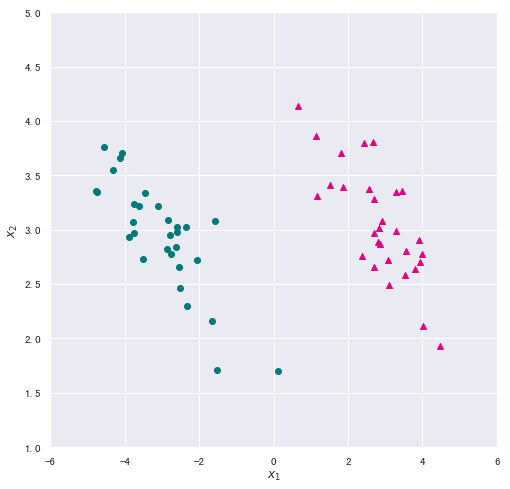

In [280]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 8)) #设置图片尺寸

plt.scatter(data_pos["x1"],data_pos["x2"],c="#E4007F",marker="^") # 类别为1的数据绘制成洋红色
plt.scatter(data_neg["x1"],data_neg["x2"],c="#007979",marker="o") # 类别为-1的数据绘制成深绿色

plt.xlabel("$x_1$") #设置横轴标签
plt.ylabel("$x_2$") #设置纵轴标签

plt.xlim(-6,6) #设置横轴显示范围
plt.ylim(1,5) #设置纵轴显示范围
plt.show()

假设我们学习到的决策直线方程为  $w_1 x_1 + w_2 x_2 + w_0 = 0$，即直线上的点满足以下关系 $x_2 = - \frac{w_1}{w_2} x_1  - \frac{w_0}{w_2}$。所以一旦得到直线方程，我们首先生成横轴数据 x1，然后根据上述公式计算对应的纵轴取值 x2 ，最后利用 `matplotlib` 的 `plot` 函数就可以将直线绘制出来。

In [281]:
import numpy as np
w = [1,1,-4]
x1 = np.linspace(-6, 6, 50)
x2 = - (w[0]/w[1])*x1 - w[2]/w[1]

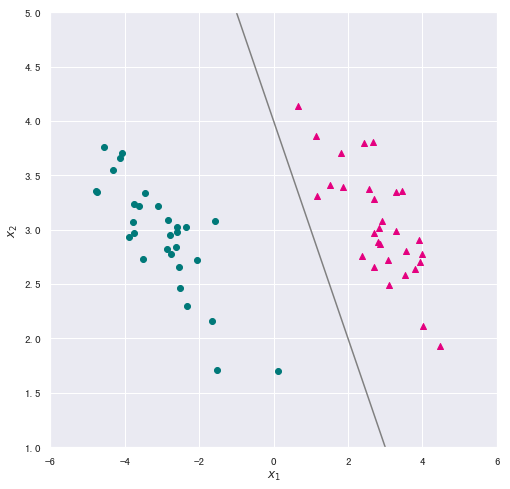

In [282]:
plt.figure(figsize=(8, 8)) #设置图片尺寸

plt.scatter(data_pos["x1"],data_pos["x2"],c="#E4007F",marker="^") # 类别为1的数据绘制成洋红色
plt.scatter(data_neg["x1"],data_neg["x2"],c="#007979",marker="o") # 类别为-1的数据绘制成深绿色
plt.plot(x1,x2,c="gray") # 画出分类直线

plt.xlabel("$x_1$") #设置横轴标签
plt.ylabel("$x_2$") #设置纵轴标签

plt.xlim(-6,6) #设置横轴显示范围
plt.ylim(1,5) #设置纵轴显示范围
plt.show()

# <a id=2></a> 2 感知机模型

感知机的损失函数为$ L(\mathbf{w}) = -\mathop{\sum}\limits_{\boldsymbol{x}_{i} \in M}y_i( \mathbf{w}^{\text{T}}\boldsymbol{x}_i)$，其中$M$为误分类样本集合。训练姐中没有误分类样本时,损失函数$L(\mathbf{w})$为0，误分类样本数量越少，误分类样本与超平面的距离就越近，因此损失函数也就越小。

可由损失函数得出梯度如下：
$$\nabla_{\mathbf{w}}L(\mathbf{w}) = -\sum\limits_{\boldsymbol{x}_i\in M} y_i\boldsymbol{x}_i$$

随机选取一个误分类样本$(\boldsymbol{x}_i,y_i)$，对参数$\mathbf{w}$的更新方法如下：

$$\mathbf{w}^{(t+1)} \leftarrow \mathbf{w}^{(t)} + \eta y_i \boldsymbol{x}_i$$

其中$\eta$为学习率，$0<\eta\leq1$，这样通过迭代就可以使损失函数减小，直到损失函数为0。


使用随机梯度下降法的感知机算法为:
<img src="http://cookdata.cn/media/note_images/感知机SGD_1590629175430_5d14.jpg" height="500" width="400" >


下面用一个 `perception` 函数实现上述算法。为了深入观察算法运行过程，我们保留了每一轮迭代的参数 $\mathbf{w}$，并对每一轮迭代中随机选取的样本也进行了记录。所以，`perception` 函数返回三个取值: 最终学习到的参数 `w`, 每轮迭代的参数 `W`, 每轮迭代随机选取的样本 `mis_samples` 。

In [283]:
def perception(X,y,learning_rate,max_iter=1000):
    w = pd.Series(data=np.zeros_like(X.iloc[0]),index=X.columns) # 初始化参数 w0
    W = [w] # 定义一个列表存放每次迭代的参数
    mis_samples = [] # 存放每次误分类的样本
    
    for t in range(max_iter):
        
        # 2.1 寻找误分类集合 M
        m = (X.dot(w))*y #yw^Tx < 0 的样本为误分类样本
        X_m = X[m <= 0]  # 误分类样本的特征数据
        y_m = y[m <= 0]  # 误分类样本的标签数据
        
        if(len(X_m) > 0): # 如果有误分类样本，则更新参数；如果不再有误分类样本，则训练完毕。
            # 2.2 从 M 中随机选取一个样本 i 
            i = np.random.randint(len(X_m))
            mis_samples.append(X_m.iloc[i,:])
            # 2.3 更新参数 w 
            w = w + learning_rate * y_m.iloc[i]*X_m.iloc[i,:]
            W.append(w)
        else: 
            break
            
    mis_samples.append(pd.Series(data=np.zeros_like(X.iloc[0]),index=X.columns))
    return w,W,mis_samples

现在，让我们使用上一节生成的数据集来测试一下上述感知机算法吧。

In [288]:
w_percept,W,mis_samples = perception(data[["x1","x2","ones"]], data["label"],1,max_iter=1000)

首先，将学习到的感知机的决策直线可视化，观察分类效果。

In [289]:
x1 = np.linspace(-6, 6, 50)
x2 = - (w_percept[0]/w_percept[1])*x1 - w_percept[2]/w_percept[1]

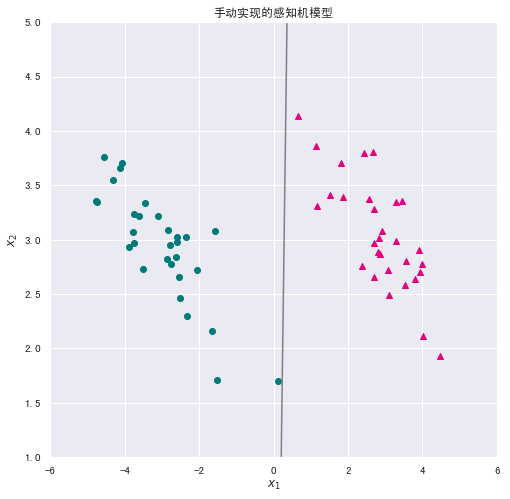

In [290]:
plt.figure(figsize=(8, 8)) #设置图片尺寸

plt.scatter(data_pos["x1"],data_pos["x2"],c="#E4007F",marker="^") # 类别为1的数据绘制成洋红色
plt.scatter(data_neg["x1"],data_neg["x2"],c="#007979",marker="o") # 类别为-1的数据绘制成深绿色
plt.plot(x1,x2,c="gray") # 画出分类直线

plt.xlabel("$x_1$") #设置横轴标签
plt.ylabel("$x_2$") #设置纵轴标签
plt.title('手动实现的感知机模型')
plt.xlim(-6,6) #设置横轴显示范围
plt.ylim(1,5) #设置纵轴显示范围
plt.show()

由于已经记录了每一轮迭代中参数和选取的样本，我们将感知机的学习过程动态展示出来。我们可以借助 `matplotlib.animation` 动画模块来实现。在我们的动画中，样本数据保持不变，每个图片中变化的是决策实现和随机选取的样本。下面的 `init_draw` 函数是动画最开始时绘制的内容，只包含数据。`update_draw` 则是每次更新的内容，我们根据参数将决策直线进行更新，将选取的样本用圆圈进行标记。

In [291]:
#plt.rcParams['figure.dpi'] = 120 #分辨率
fig, ax = plt.subplots(figsize=(8, 8))
line, = ax.plot([],[],c="gray")  ## 决策直线对象
dot, = ax.plot([],[],"go", linewidth=2, markersize=12,markerfacecolor='none') ## 误分类样本对象

def init_draw(): # 展现样本数据
    ax.set_title("感知机训练过程")
    ax.scatter(data_pos["x1"],data_pos["x2"],c="#E4007F",marker="^") # 类别为1的数据绘制成洋红色
    ax.scatter(data_neg["x1"],data_neg["x2"],c="#007979",marker="o") # 类别为-1的数据绘制成深绿色
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.xlim(-6,6)
    plt.ylim(1,5)
        
def update_draw(i): # 实现动画中每一帧的绘制函数，i为第几帧
    ax.set_title("感知机训练过程 "+ str(i))
    w = W[i] #获取当前迭代的参数
    x1 = np.linspace(-6, 6, 50)
    x2 = - (w[0]/w[1])*x1 - w[2]/w[1] 
    line.set_data(x1,x2) #更新决策直线绘制
    dot.set_data(mis_samples[i]["x1"],mis_samples[i]["x2"]) # 更新选取的样本标记
    plt.close()
    
#演示决策面动态变化
import matplotlib.animation as animation
from IPython.display import HTML
animator = animation.FuncAnimation(fig, update_draw, frames= range(0,len(W)), init_func=init_draw,interval=2000)
HTML(animator.to_jshtml())

/explorer/pyenv/jupyter-py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


# <a id=3></a>3 逻辑回归实现

接下来，我们将分别使用两种不同的优化方法进行逻辑回归算法的实现。已知逻辑回归的目标函数为负对数似然函数 $ \text{NLL}(\mathbf{w})=\sum_{i=1}^{n} \ln (1 + e^{-y_i \mathbf{w}^{\rm T} \mathbf{x}_i})$，梯度为 $\nabla  \text{NLL}(\mathbf{w}) = - \sum_{i=1}^{n} \frac{y_i \mathbf{x}_i}{1 + e^{y_i \mathbf{w}^{\rm T} \mathbf{x}_i}}$ ，则：
1. 使用梯度下降法求解的迭代公式为：
$$
\mathbf{w}^{(t + 1)} \leftarrow \mathbf{w}^{(t)} + \eta_t \sum_{i=1}^{n} \frac{y_i \mathbf{x}_i}{1 + e^{y_i {\mathbf{w}^{(t)}}^{\rm T} \mathbf{x}_i}}
$$

2. 使用随机梯度下降法的迭代求解公式为：
$$
\mathbf{w}^{(t + 1)} \leftarrow \mathbf{w}^{(t)} + \eta_t \frac{y_i x_i}{1 + e^{y_i {\mathbf{w}^{(t)}}^{\rm T} \mathbf{x}_i}}
$$

## <a id=3.1></a> 3.1 梯度下降法求解逻辑回归

首先，我们来一起实现使用梯度下降求解的逻辑回归算法：

In [292]:
import numpy as np
# 定义梯度下降法求解的迭代公式
def logistic_regression(X,y,learning_rate,max_iter=1000):
    # 初始化w
    w = np.zeros(X.shape[1])
    for t in range(max_iter):      
        # 计算yX
        yx = y.values.reshape((len(y),1)) * X 
        # 计算1 + e^(yXW)
        logywx = (1 +  np.power(np.e,X.dot(w)*y)).values.reshape(len(y),1) 
        w_grad = np.divide(yx,logywx).sum()
        # 迭代w
        w = w + learning_rate * w_grad    
    return w

我们将数据及标签带入上面定义的函数，学习率设为 0.5 ，迭代次数为1000次，输出训练好的参数，并将分类结果进行可视化。

x1      43.891185
x2      -4.351429
ones    -3.605057
dtype: float64


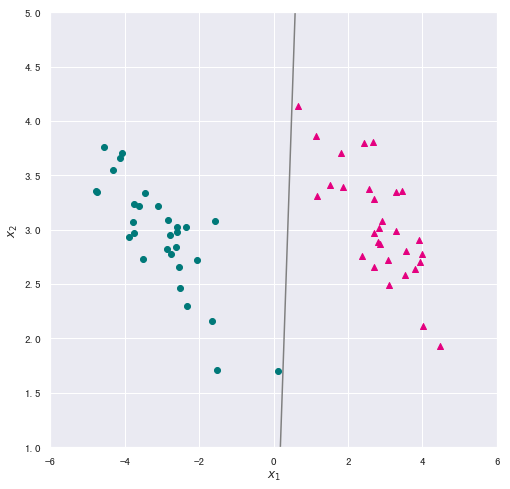

In [293]:
# 输出训练好的参数
w = logistic_regression(data[["x1","x2","ones"]], data["label"],0.5,max_iter=1000)  
print(w)

# 可视化分类结果
x1 = np.linspace(-6, 6, 50)
x2 = - (w[0]/w[1])*x1 - w[2]/w[1]

plt.figure(figsize=(8, 8))
plt.scatter(data_pos["x1"],data_pos["x2"],c="#E4007F",marker="^") # 类别为1的数据绘制成洋红色
plt.scatter(data_neg["x1"],data_neg["x2"],c="#007979",marker="o") # 类别为-1的数据绘制成深绿色
plt.plot(x1,x2,c="gray")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-6,6)
plt.ylim(1,5)
plt.show()

## <a id=3.2></a> 3.2 随机梯度下降法求解逻辑回归

接下来，我们一起实现使用随机梯度下降法的逻辑回归算法，随机梯度下降法的迭代求解公式为：
$$
\mathbf{w}^{(t + 1)} \leftarrow \mathbf{w}^{(t)} + \eta_t \frac{y_i x_i}{1 + e^{y_i {\mathbf{w}^{(t)}}^{\rm T} x_i}}
$$

In [294]:
# 定义随机梯度下降法求解的迭代公式
def logistic_regression_sgd(X,y, learning_rate, max_iter=1000): 
    # 初始化w
    w = np.zeros(X.shape[1])
    for t in range(max_iter):
        # 随机选择一个样本
        i = np.random.randint(len(X))
        # 计算yx
        yixi = y[i] * X.values[i]
         # 计算1 + e^(yxW)
        logyiwxi = 1 +  np.power(np.e, w.T.dot(X.values[i])*y[i])
        w_grad = yixi / logyiwxi
        
        # 迭代w
        w = w + learning_rate * w_grad  
        
    return w

我们将学习率设为 0.5，迭代次数为1000次，并输出训练好的参数，将分类结果可视化。

[ 4.00674258  0.68954889 -2.29276599]


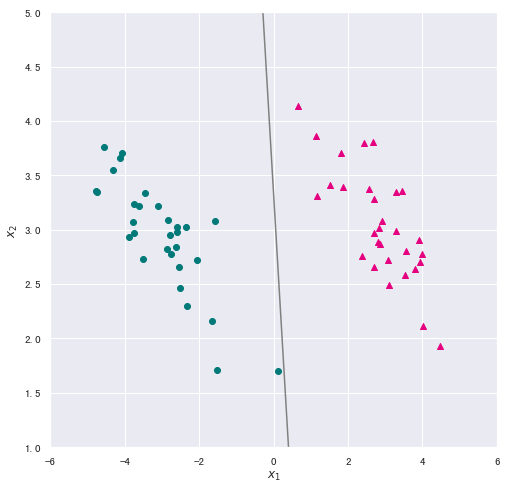

In [295]:
# 输出训练好的参数
w = logistic_regression_sgd(data[["x1","x2","ones"]], data["label"],0.5,max_iter=1000)  
print(w)

# 可视化分类结果
x1 = np.linspace(-6, 6, 50)
x2 = - (w[0]/w[1])*x1 - w[2]/w[1]

plt.figure(figsize=(8, 8))
plt.scatter(data_pos["x1"],data_pos["x2"],c="#E4007F",marker="^") # 类别为1的数据绘制成洋红色
plt.scatter(data_neg["x1"],data_neg["x2"],c="#007979",marker="o") # 类别为-1的数据绘制成深绿色
plt.plot(x1,x2,c="gray")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-6,6)
plt.ylim(1,5)
plt.show()

# <a id=4></a>4 支持向量机实现

线性支持向量机的优化目标为 $\text{L}(\mathbf{w}) = \frac{\lambda}{2} \Vert \mathbf{w} \Vert_2^2 + \sum_{i=1}^{n}\max(0, 1-y_i\mathbf{w}^{\rm T}\mathbf{x}_i )$ 。 我们使用pegasos算法进行优化，它类似于随机梯度下降法，每次使用一个样本计算梯度并更新参数，并且学习率会随着迭代次数不断变化。那么第$t$轮迭代参数的梯度为：
$$
\nabla \text{L}(\mathbf{w})= \lambda \mathbf{w}_{t} - \text{I}( y_i\mathbf{w}_{t}^{\rm T}\mathbf{x}_i < 1) y_i \mathbf{x}_i.
$$
学习率$\eta_{t}$的公式为：
$$\eta_{t} = \frac{1}{\lambda t}$$
参数更新公式为：
$$\mathbf{w}_{t+1} \leftarrow \mathbf{w}_{t} - \eta_{t}\nabla \text{L}(\mathbf{w})$$

下面我们实现上述算法，函数名为 `linear_svm`，主要的输入参数包括训练集特征部分 `X`，训练集标签 `y`, 惩罚系数 `lam` 和最大迭代轮数 `max_iter` 等，函数输出训练得到的参数和支持向量。

In [296]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 定义函数
def linear_svm(X,y,lam,max_iter=2000):  
    w = np.zeros(X.shape[1]) # 初始化w
    support_vectors = [] # 创建空列表保存支持向量
    
    for t in range(max_iter): # 进行迭代
        
        learning_rate = 1/(lam * (t + 1)) # 计算本轮迭代的学习率
        i = np.random.randint(len(X)) # 从训练集中随机抽取一个样本
        ywx = w.T.dot(X.values[i])*y[i]  # 计算y_i w^T x_i
        
        if ywx < 1:# 进行指示函数的判断
            w = w - learning_rate * lam*w + learning_rate * y[i] * X.values[i] # 更新参数       
        else:
            w = w - learning_rate * lam*w # 更新参数
    for i in range(len(X)):
        ywx = w.T.dot(X.values[i])*y[i]  # 计算y_i w^T x_i
        if ywx <= 1: # 根据样本是否位于间隔附近判断是否为支持向量
            support_vectors.append(X.values[i])
    
    return w,support_vectors

需要注意的是，线性支持向量机的正则化项通常不包括截距项，我们可以将数据进行中心化，再调用上述代码。

In [299]:
# 对训练集数据进行归一化，则模型无需再计算截距项
X = data[["x1","x2"]].apply(lambda x: x - x.mean())
# 训练集标签
y = data["label"]
w,support_vectors = linear_svm(X,y, lam=0.05, max_iter=5000)

将得到的超平面可视化，同时将两个函数间隔为 1 的线也绘制出来。对于所有不满足约束的样本，使用圆圈标记出来。

(-2, 2)

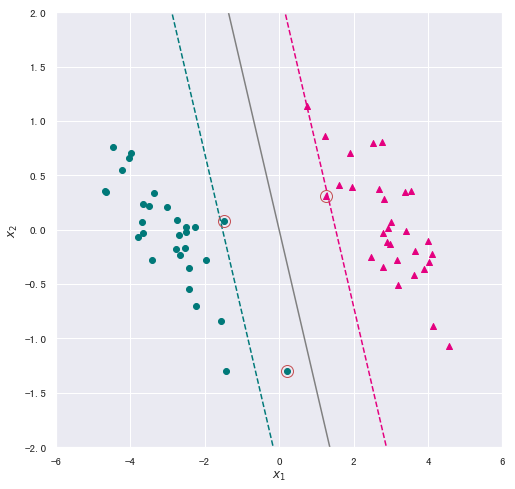

In [308]:
# 创建绘图框
plt.figure(figsize=(8, 8))
# 绘制两类样本点
X_pos = X[ y==1 ]
X_neg = X[ y==-1 ]
plt.scatter(X_pos["x1"],X_pos["x2"],c="#E4007F",marker="^") # 类别为1的数据绘制成洋红色
plt.scatter(X_neg["x1"],X_neg["x2"],c="#007979",marker="o") # 类别为-1的数据绘制成深绿色

# 绘制超平面
x1 = np.linspace(-6, 6, 50)
x2 = - w[0]*x1/w[1]
plt.plot(x1,x2,c="gray")

# 绘制两个间隔超平面
plt.plot(x1,-(w[0]*x1+1)/w[1],"--",c="#007979")
plt.plot(x1,-(w[0]*x1-1)/w[1],"--",c="#E4007F")

# 标注支持向量
for x in support_vectors:
    plt.plot(x[0],x[1],"ro", linewidth=2, markersize=12,markerfacecolor='none')
    
# 添加轴标签和限制轴范围
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-6,6)
plt.ylim(-2,2)

# <a id=5></a> 5 新闻主题分类模型构建

在第一讲中（[机器学习第一讲：机器学习介绍](http://cookdata.cn/auditorium/course_room/10012/)，[使用KNN对新闻主题进行自动分类](http://cookdata.cn/note/view_static_note/ca759b585803e5a3fb8e0f5053cd010e/)），我们使用 KNN 构建了新闻主题分类模型，在本案例中，使用感知机、逻辑回归和支持向量机构建新闻主题分类模型并评估模型分类效果。

首先我们读取已经过分词的新闻数据。

In [309]:
raw_train = pd.read_csv("./input/chinese_news_cutted_train_utf8.csv",sep="\t",encoding="utf8")
raw_test = pd.read_csv("./input/chinese_news_cutted_test_utf8.csv",sep="\t",encoding="utf8")

查看训练集的前5行。

In [310]:
raw_train.head()

,分类,分词文章
0,科技,“ 一路 听 天下 ” 开拓 “ 无聊 经济 ” 在 纳斯达克 风光 上市 的 分众传媒...
1,旅游,中国 赴美 旅游 首发 团 ６ 月 １ ７ 日 启程 报价 两万左右 六月 初 的 ...
2,新闻,科学家 教育家 蒙特 梭利 ： 给 孩子 爱 与 自由 （ 图 ） 蒙特 梭利 和 “ ...
3,教育,７ 名 大学生 作出 “ 震后 恢复 建议 ” 获 国务院 肯定 大学生 灾后 重建...
4,教育,最牛 高 考生 ： 重庆 学生 称 “ 押 中 ” 今年 作文题 最牛 鼓劲 ： 数学考...


为了简单，我们这里先只考虑二分类，我们选取主题为"科技"和“文化”新闻。

In [311]:
raw_train_binary = raw_train[((raw_train["分类"] == "科技") | (raw_train["分类"] == "文化"))]
raw_test_binary = raw_test[((raw_test["分类"] == "科技") | (raw_test["分类"] == "文化"))]

In [312]:
raw_test_binary.head()

,分类,分词文章
2,文化,欧阳奋强 点评 新 宝玉 ： 他 应该 能够 超越 我 （ 图 ） 来源 ： 中国 网 ...
6,文化,为防 地震 灾害 苏州园林 留下 “ 重生 密码 ” 中新社 苏州 六月 十四日 电...
28,文化,销声匿迹 多年 的 董文华 难掩 沧桑 老态 跳转 至 ： 页 ４ ／ ７ 我 来说...
33,科技,胡锦涛 网聊 ２ ０ 分钟 网友 期待 半年 终于 成 真 （ 组图 ） 胡锦涛 称...
38,科技,【 编者按 】 在 这个 多事之秋 ， 奥克斯 带 着 一本 《 手机 成本 白皮书 》...


加载停用词表，用于去除文本中的停用词。

In [313]:
# 加载停用词
stop_words = []
file = open("./input/stopwords.txt") 
for line in file:
    stop_words.append(line.strip())
file.close()

将文本数据转换为词向量。基本的思路是将新闻中词去掉停用词后，构成一个词典。将每一个新闻转换成词典大小的向量，向量每一个维度的取值为对应的词在新闻中出现的次数。`skleran.feature_extraction.text` 模块的 `CountVectorizer` 模块已经帮助我们实现了这个功能。我们首先构建一个 CountVectorizer 对象 `vectorizer`，然后调用其 `fit_transform` 方法，训练集的分词内容作为输入，就能完成词典的构建和训练集的向量化转换。最后调用 `transform` 方法完成对测试集的向量化转换。

In [314]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=stop_words)
X_train = vectorizer.fit_transform(raw_train_binary["分词文章"])
X_test = vectorizer.transform(raw_test_binary["分词文章"])

调用 `sklearn` 中随机梯度下降分类器 `SGDClassifier` ,通过设置损失函数 `loss` 分别为 `perceptron`、 `log` 和 `hinge` 分别构建感知机、逻辑回归和线性支持向量机模型。

In [316]:
from sklearn.linear_model import SGDClassifier

percep_clf = SGDClassifier(loss="perceptron",penalty=None,learning_rate="constant",eta0=1.0,max_iter=1000,random_state=111)
lr_clf = SGDClassifier(loss="log",penalty=None,learning_rate="constant",eta0=1.0,max_iter=1000,random_state=111)
lsvm_clf = SGDClassifier(loss="hinge",penalty="l2",alpha=0.0001,learning_rate="constant",eta0=1.0,max_iter=1000,random_state=111)

In [319]:
# 训练感知机模型
percep_clf.fit(X_train,raw_train_binary["分类"])
# 输出测试集分类正确率
round(percep_clf.score(X_test,raw_test_binary["分类"]),2)

0.9

In [320]:
# 训练逻辑回归模型
lr_clf.fit(X_train,raw_train_binary["分类"])
# 输出测试集分类正确率
round(lr_clf.score(X_test,raw_test_binary["分类"]),2)

0.91

In [321]:
# 训练线性支持向量机模型
lsvm_clf.fit(X_train,raw_train_binary["分类"])
# 输出测试集分类正确率
round(lsvm_clf.score(X_test,raw_test_binary["分类"]),2)

0.94

从测试集分类正确率上看，线性支持向量机模型的效果要优于其它两个模型。

# <a id=6></a> 6 模型效果评估
下面使用混淆矩阵来分析模型在测试集上的表现。混淆矩阵从样本的真实标签和模型预测标签两个维度对测试集样本进行分组统计，然后以矩阵的形式展示。借助混淆矩阵可以很好地分析模型在每一类样本上的分类效果。为了更直观地分析，我们借助 Python 中的可视化库 Seaborn 提供的 heatmap 函数，将线性支持向量机模型的混淆矩阵进行可视化。

Text(0.5, 1.0, '混淆矩阵热力图')

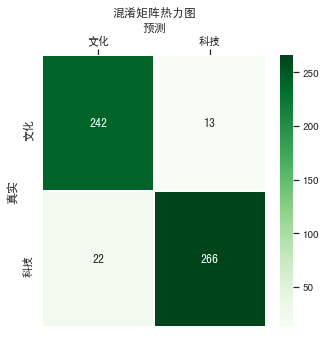

In [323]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
# 设置正常显示中文
sns.set(font='SimHei')
# 绘制热力图
y_svm_pred = lsvm_clf.predict(X_test) # 预测标签
y_test_true = raw_test_binary["分类"] #真实标签
confusion_matrix = confusion_matrix(y_svm_pred,y_test_true)#计算混淆矩阵
ax = sns.heatmap(confusion_matrix,linewidths=.5,cmap="Greens",
                 annot=True, fmt='d',xticklabels=lsvm_clf.classes_, yticklabels=lsvm_clf.classes_)
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.set_title('混淆矩阵热力图')

# <a id=7></a> 7 总结

在本案例中，我们使用随机梯度方法实现了三种使用回归的思想来解决分类问题的模型：感知机、逻辑回归和线性支持向量机。在实现时主要使用了 `NumPy`, `Pandas` 和 `Matplotlib` 等 Python 库。在 `Sklearn` 中，`linear.model.SGDClassifier` 类实现了常见算法的随机梯度下降实现。我们使用该类，在一份中文新闻数据上分别用随机梯度下降算法训练了感知机、逻辑回归和线性支持向量机模型，实现了对中文新闻主题的分类。最后，使用 `Sklearn.metrics` 实现的模型评价方法，用正确率和混淆矩阵对分类效果进行了简单的分析。

附：以下为绘制三种分类模型的损失函数曲线代码。

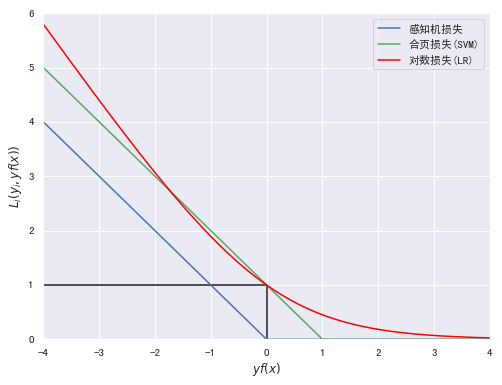

In [324]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
yfx = np.linspace(-4, 4, 500)
perception = [0 if i >= 0 else -i for i in yfx]
hinge = [(1-i) if i <= 1 else 0 for i in yfx]
log = np.log2(1 + np.power(np.e,-yfx))
plt.figure(figsize=(8, 6))
plt.plot(yfx,perception,c="b",label="感知机损失")
plt.plot(yfx,hinge,c="g",label="合页损失(SVM)")
plt.plot(yfx,log,c="red",label="对数损失(LR)")
plt.hlines(1,-4,0)
plt.vlines(0,0,1)
plt.xlabel("$yf(x)$")
plt.ylabel("$L_i(y_i,yf(x))$")
plt.xlim(-4,4)
plt.ylim(0,6)
plt.legend()

附：以下为绘制三种分类模型的从回归到分类的映射函数。

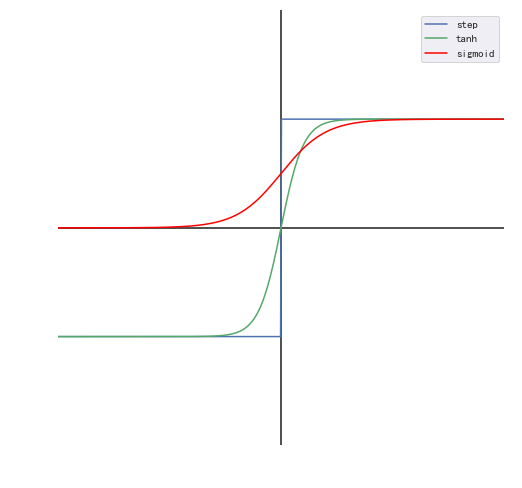

In [325]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#创建画布并引入axisartist工具。
import mpl_toolkits.axisartist as axisartist
#创建画布
fig = plt.figure(figsize=(8, 8))
fx = np.linspace(-10, 10, 500)
step = [1 if i >= 0 else -1 for i in fx]
tanh = np.tanh(fx)
sigmoid = 1/(1 + np.power(np.e,-fx))
plt.axhline(0,-10,10,color="k")
plt.axvline(0,-2,2,color="k")
plt.plot(fx,step,c="b",label="step")
plt.plot(fx,tanh,c="g",label="tanh")
plt.plot(fx,sigmoid,c="red",label="sigmoid")
plt.xlabel("$f$")
plt.ylabel("$H(f)$")
plt.grid(False)
plt.xlim(-10, 10)
plt.ylim(-2,2)
plt.axis('off')
plt.legend()